# **Miniproject - fake/real faces classifications using CNN**

In [1]:
import pandas as pd


In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"claudehallard","key":"6570efbb31846c362442bf200cf1f551"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                     COVID-19 Dataset                                     5MB  2022-11-13 15:47:17          14940        423  1.0              
devrimtuner/list-of-moststreamed-songs-on-spotify             Top 100 Spotify Songs👑🎤🎧🎼                            3KB  2022-12-30 05:42:54            319         26  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india  Credit Card Spending Habits in India               319KB  2022-12-14 07:30:37           1513         51  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset            Fifa World Cu

In [7]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

100% 3.75G/3.75G [01:56<00:00, 41.4MB/s]
100% 3.75G/3.75G [01:56<00:00, 34.5MB/s]


In [ ]:
!unzip 140k-real-and-fake-faces.zip

In [9]:
df_train = pd.read_csv('train.csv',index_col=0)
df_val = pd.read_csv('valid.csv',index_col=0)
df_test = pd.read_csv('test.csv',index_col=0)

## **Load data**

In [ ]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

path = "real_vs_fake/real-vs-fake"

datagen = ImageDataGenerator(rescale=1./255, zca_whitening = True, horizontal_flip=True)
training_set = datagen.flow_from_directory(path + '/train',
                                           class_mode='binary',
                                           shuffle = True,
                                           target_size=(32,32),
                                           batch_size = 96
                                          )
test_set = datagen.flow_from_directory(path + '/test',
                                       class_mode='binary',
                                       shuffle = False,
                                       target_size=(32,32),
                                       batch_size = 96
                                       )
validation_set = datagen.flow_from_directory(path + '/valid',
                                        class_mode='binary',
                                        shuffle = False,
                                        target_size=(32,32),
                                        batch_size = 96
                                            )

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1285: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# **CNN densenet model using pretrained weights, learning rate 0.001. (This one actually has around 9 epochs because of an interrupt when running)**

In [ ]:
# DenseNet121 parameter weights lets you use pre-trained weights from the imagenet dataset
densenet = DenseNet121(weights='imagenet', include_top = False, input_shape=(32,32,3))

model = Sequential([densenet,
                    GlobalAveragePooling2D(),
                    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
history = model.fit(training_set,
          steps_per_epoch=(100000/96),
          validation_data=validation_set,
          validation_steps = (20000/96),
          epochs= 5)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
1041/1041 [==============================] - 2088s 2s/step - loss: 0.4577 - accuracy: 0.7830 - val_loss: 0.4922 - val_accuracy: 0.7643
Epoch 2/5
1041/1041 [==============================] - 2131s 2s/step - loss: 0.3393 - accuracy: 0.8514 - val_loss: 0.3754 - val_accuracy: 0.8328
Epoch 3/5
1041/1041 [==============================] - 2123s 2s/step - loss: 0.2903 - accuracy: 0.8764 - val_loss: 0.3745 - val_accuracy: 0.8372
Epoch 4/5
1041/1041 [==============================] - 2160s 2s/step - loss: 0.2491 - accuracy: 0.8968 - val_loss: 0.3755 - val_accuracy: 0.8453
Epoch 5/5
1041/1041 [==============================] - 2161s 2s/step - loss: 0.2725 - accuracy: 0.8852 - val_loss: 0.3213 - val_accuracy: 0.8644


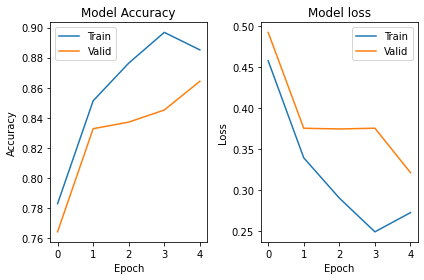

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history["accuracy"])
ax1.plot(history.history["val_accuracy"])
ax1.title.set_text("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Train", "Valid"])

ax2.plot(history.history["loss"])
ax2.plot(history.history["val_loss"])
ax2.title.set_text("Model loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Train", "Valid"])
plt.tight_layout()
plt.show()

In [ ]:
xTest = model.predict(test_set)
yTest = test_set.classes

209/209 [==============================] - 102s 473ms/step


In [ ]:
print(classification_report(yTest, xTest > 0.5))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     10000
           1       0.92      0.79      0.85     10000

    accuracy                           0.86     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.87      0.86      0.86     20000



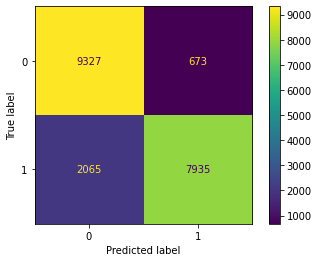

In [ ]:
cm = confusion_matrix(yTest, xTest.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## **1.1 CNN densenet model without pretrained weights**

In [ ]:
datagen1 = ImageDataGenerator(rescale=1./255, zca_whitening = True, horizontal_flip=True)
training_set1 = datagen1.flow_from_directory(path + '/train',
                                           class_mode='binary',
                                           shuffle = True,
                                           target_size=(32,32),
                                           batch_size = 96
                                          )
test_set1 = datagen1.flow_from_directory(path + '/test',
                                       class_mode='binary',
                                       shuffle = False,
                                       target_size=(32,32),
                                       batch_size = 96
                                       )
validation_set1 = datagen1.flow_from_directory(path + '/valid',
                                        class_mode='binary',
                                        shuffle = False,
                                        target_size=(32,32),
                                        batch_size = 96
                                            )

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
# DenseNet121 parameter weights lets you use pre-trained weights from the imagenet dataset
densenet1 = DenseNet121(weights=None, include_top = False, input_shape=(32,32,3))

model1 = Sequential([densenet1,
                    GlobalAveragePooling2D(),
                    Dense(1, activation='sigmoid')])
model1.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
history1 = model1.fit(training_set1,
          steps_per_epoch=(100000/100),
          validation_data=validation_set,
          validation_steps = (20000/100),
          epochs= 5)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
1000/1000 [==============================] - 2083s 2s/step - loss: 0.7192 - accuracy: 0.4811 - val_loss: 0.7547 - val_accuracy: 0.4792
Epoch 2/5
1000/1000 [==============================] - 2117s 2s/step - loss: 0.7162 - accuracy: 0.4692 - val_loss: 3.3391 - val_accuracy: 0.4792
Epoch 3/5
1000/1000 [==============================] - 2127s 2s/step - loss: 0.7187 - accuracy: 0.5077 - val_loss: 0.8390 - val_accuracy: 0.5183
Epoch 4/5
1000/1000 [==============================] - 2129s 2s/step - loss: 0.7092 - accuracy: 0.5108 - val_loss: 0.7288 - val_accuracy: 0.4787
Epoch 5/5
1000/1000 [==============================] - 2130s 2s/step - loss: 0.7115 - accuracy: 0.4882 - val_loss: 0.8768 - val_accuracy: 0.5261


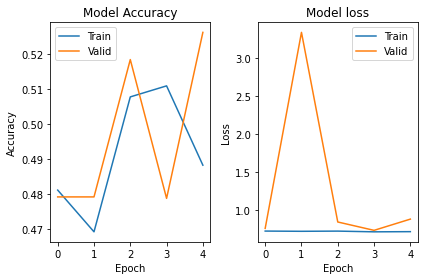

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history1.history["accuracy"])
ax1.plot(history1.history["val_accuracy"])
ax1.title.set_text("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Train", "Valid"])

ax2.plot(history1.history["loss"])
ax2.plot(history1.history["val_loss"])
ax2.title.set_text("Model loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Train", "Valid"])
plt.tight_layout()
plt.show()

In [ ]:
xTest1 = model1.predict(test_set1)
yTest1 = test_set.classes

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


209/209 [==============================] - 101s 478ms/step


In [ ]:
print(classification_report(yTest1, xTest1 > 0.5))

              precision    recall  f1-score   support

           0       0.51      0.90      0.65     10000
           1       0.55      0.11      0.19     10000

    accuracy                           0.51     20000
   macro avg       0.53      0.51      0.42     20000
weighted avg       0.53      0.51      0.42     20000



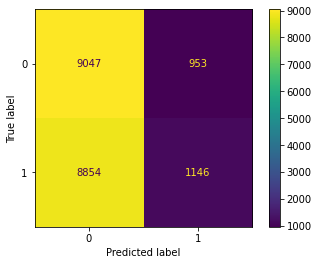

In [ ]:
cm = confusion_matrix(yTest1, xTest1.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## **1.2 CNN densenet model with pretrained weights and set learning rate**

In [10]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

path = "real_vs_fake/real-vs-fake"

datagen2 = ImageDataGenerator(rescale=1./255, zca_whitening = True, horizontal_flip=True)
training_set2 = datagen2.flow_from_directory(path + '/train',
                                           class_mode='binary',
                                           shuffle = True,
                                           target_size=(32,32),
                                           batch_size = 96
                                          )
test_set2 = datagen2.flow_from_directory(path + '/test',
                                       class_mode='binary',
                                       shuffle = False,
                                       target_size=(32,32),
                                       batch_size = 96
                                       )
validation_set2 = datagen2.flow_from_directory(path + '/valid',
                                        class_mode='binary',
                                        shuffle = False,
                                        target_size=(32,32),
                                        batch_size = 96
                                            )

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1285: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [13]:
# DenseNet121 parameter weights lets you use pre-trained weights from the imagenet dataset
from keras.optimizers import Adam
densenet2 = DenseNet121(weights='imagenet', include_top = False, input_shape=(32,32,3))
optimizer = Adam(learning_rate=0.003)


model2 = Sequential([densenet2,
                    GlobalAveragePooling2D(),
                    Dense(1, activation='sigmoid')])
model2.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [16]:
history2 = model2.fit(training_set2,
          steps_per_epoch=(100000/100),
          validation_data=validation_set2,
          validation_steps = (20000/100),
          epochs= 5)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
1000/1000 [==============================] - 1362s 1s/step - loss: 0.6744 - accuracy: 0.6026 - val_loss: 1.0770 - val_accuracy: 0.5066
Epoch 2/5
1000/1000 [==============================] - 1391s 1s/step - loss: 0.5997 - accuracy: 0.6886 - val_loss: 1.1163 - val_accuracy: 0.4991
Epoch 3/5
1000/1000 [==============================] - 1429s 1s/step - loss: 0.5557 - accuracy: 0.7211 - val_loss: 0.8942 - val_accuracy: 0.4812
Epoch 4/5
1000/1000 [==============================] - 1435s 1s/step - loss: 0.5753 - accuracy: 0.7081 - val_loss: 1.3545 - val_accuracy: 0.5491
Epoch 5/5
1000/1000 [==============================] - 1449s 1s/step - loss: 0.5200 - accuracy: 0.7419 - val_loss: 1.0324 - val_accuracy: 0.5681


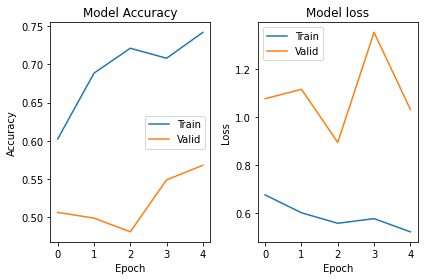

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history2.history["accuracy"])
ax1.plot(history2.history["val_accuracy"])
ax1.title.set_text("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Train", "Valid"])

ax2.plot(history2.history["loss"])
ax2.plot(history2.history["val_loss"])
ax2.title.set_text("Model loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Train", "Valid"])
plt.tight_layout()
plt.show()

In [20]:
xTest2 = model2.predict(test_set2)
yTest2 = test_set2.classes

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


209/209 [==============================] - 74s 352ms/step


In [21]:
print(classification_report(yTest2, xTest2 > 0.5))

              precision    recall  f1-score   support

           0       0.87      0.21      0.34     10000
           1       0.55      0.97      0.70     10000

    accuracy                           0.59     20000
   macro avg       0.71      0.59      0.52     20000
weighted avg       0.71      0.59      0.52     20000



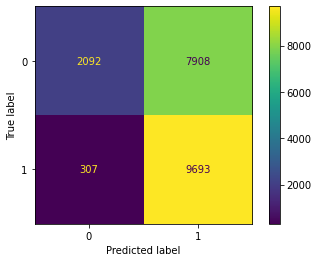

In [22]:
cm = confusion_matrix(yTest2, xTest2.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## **1.3 CNN densenet model with default learning rate and pretrained weights**

In [23]:
from keras.optimizers import Adam
densenet3 = DenseNet121(weights='imagenet', include_top = False, input_shape=(32,32,3))
optimizer = Adam(learning_rate=0.001)


model3 = Sequential([densenet2,
                    GlobalAveragePooling2D(),
                    Dense(1, activation='sigmoid')])
model3.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [24]:
history3 = model3.fit(training_set2,
          steps_per_epoch=(100000/100),
          validation_data=validation_set2,
          validation_steps = (20000/100),
          epochs= 5)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
1000/1000 [==============================] - 1510s 1s/step - loss: 0.4777 - accuracy: 0.7711 - val_loss: 0.4819 - val_accuracy: 0.7706
Epoch 2/5
1000/1000 [==============================] - 1480s 1s/step - loss: 0.4302 - accuracy: 0.8005 - val_loss: 0.7108 - val_accuracy: 0.6747
Epoch 3/5
1000/1000 [==============================] - 1423s 1s/step - loss: 0.3922 - accuracy: 0.8237 - val_loss: 0.4057 - val_accuracy: 0.8144
Epoch 4/5
1000/1000 [==============================] - 1480s 1s/step - loss: 0.3663 - accuracy: 0.8375 - val_loss: 0.3744 - val_accuracy: 0.8320
Epoch 5/5
1000/1000 [==============================] - 1529s 2s/step - loss: 0.3456 - accuracy: 0.8467 - val_loss: 0.5428 - val_accuracy: 0.7532


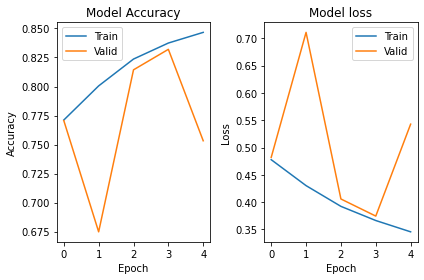

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history3.history["accuracy"])
ax1.plot(history3.history["val_accuracy"])
ax1.title.set_text("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Train", "Valid"])

ax2.plot(history3.history["loss"])
ax2.plot(history3.history["val_loss"])
ax2.title.set_text("Model loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Train", "Valid"])
plt.tight_layout()
plt.show()

In [26]:
xTest3 = model3.predict(test_set2)
yTest3 = test_set2.classes

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


209/209 [==============================] - 83s 388ms/step


In [27]:
print(classification_report(yTest3, xTest3 > 0.5))

              precision    recall  f1-score   support

           0       0.93      0.58      0.71     10000
           1       0.69      0.96      0.80     10000

    accuracy                           0.77     20000
   macro avg       0.81      0.77      0.76     20000
weighted avg       0.81      0.77      0.76     20000



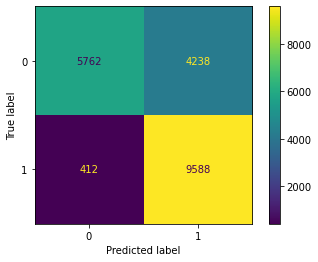

In [28]:
cm = confusion_matrix(yTest3, xTest3.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()